## Tasks and Questions:
1. What are your preliminary observations?
    - Recall for the Fraudster=True class is the most important metric for this problem because we want to catch as many fraudsters as possible.
    - However, precision could be just as imporant because we many not want to falsely accuse people of fraud.
        - The AUC-ROC curve shows us that if we rank the predictions by probability, we can get an excellent trade-off between precision and recall.
    - This is a highly imbalanced dataset with 298 fraudsters and 9646 non-fraudsters.
2. Create features:
    - Explain your reasoning behind the features
        - Many of the features have to do with the 'CREATED_DATE' because Fraudsters may work at different times than non-fraudsters.
        - The use of target encoding avoids the curse of dimensionality and is a good way to encode categorical variables.
            - It's important to use weighted target encoding to avoid overfitting.
            - It's important to use k-fold, cross-validation, target encoding to avoid data leakage.
        - Fraudsters probably use common methods for fraud
            - Features like 'SOURCE_MINOS', 'TYPE_BANK_TRANSFER', 'AMOUNT_USD'
        -Fraudsters may come from certain countries
            - COUNTRY_TARGE_ENC
        - 'STATE' was too highly correlated with the target variable, so I removed it because it is probably a data leakage variable.
3. Assess the quality of your model and explain.
    - The recall on the test set for Logistic Regression is 95% for the positive class (fraudsters).
    - The model hyperparameters should be tuned
    - Cross validation could be used to avoid overfitting. However, we didn't see much overfitting in this case.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.options.display.float_format = '{:.4f}'.format
from helpers.encoders import weighted_mean_k_fold_target_encoding, weighted_average_encoding
# 'KYC' stands for 'Know Your Customer'
#    - a process of identifying and verifying the client's identity when opening an account and periodically over time
# For regression with a lot of variables it is better to regularization techniques like Lass

In [2]:
df_users = pd.read_csv('datasets/Revolut/users.csv')
print(f'Shape: {df_users.shape}')
# make 'IS_FRAUDSTER' the first column since it's the target variable
df_users = df_users[['IS_FRAUDSTER'] + [col for col in df_users.columns if col != 'IS_FRAUDSTER']]

Shape: (9944, 11)


In [3]:
df_users_is_fraudster = df_users[df_users['IS_FRAUDSTER'] == True]
print(f'Shape: {df_users_is_fraudster.shape}')
df_users_is_fraudster.isnull().sum()

Shape: (298, 11)


IS_FRAUDSTER                0
ID                          0
HAS_EMAIL                   0
PHONE_COUNTRY               0
TERMS_VERSION              67
CREATED_DATE                0
STATE                       0
COUNTRY                     0
BIRTH_YEAR                  0
KYC                         0
FAILED_SIGN_IN_ATTEMPTS     0
dtype: int64

In [4]:
df_users = pd.read_csv('datasets/Revolut/users.csv')
print(f'Shape: {df_users.shape}')
# make 'IS_FRAUDSTER' the first column since it's the target variable
df_users = df_users[['IS_FRAUDSTER'] + [col for col in df_users.columns if col != 'IS_FRAUDSTER']]

######## FEATURE ENGINEERING ########
# Label encode the 'IS_FRAUDSTER' column. Very imbalanced dataset. 
df_users['IS_FRAUDSTER'] = df_users['IS_FRAUDSTER'].astype('category').cat.codes

# make 'HAS_EMAIL' a categorical variable
df_users['HAS_EMAIL'] = df_users['HAS_EMAIL'].astype('category').cat.codes

# drop 'TERMS_VERSION'. 8 unique values. Unlikely to be useful. 1527 null values for 'TERMS_VERSION' column.
df_users = df_users.drop(columns=['TERMS_VERSION'])

# 'STATE' column has 2 unique values 'ACTIVE' and 'LOCKED'. It appears to describe the state of the account. Make it a categorical variable, but this variable could cause data leakage.
df_users['STATE'] = df_users['STATE'].astype('category').cat.codes

# 'BIRTH_YEAR' appears to have an expected left skewed distribution with min value of 1927 and max of 2000. Bin encode this column by decade to be ordinal categorical variable.
df_users['BIRTH_YEAR'] = df_users['BIRTH_YEAR'].astype('string').str[:-1] + '0'
df_users['BIRTH_YEAR'] = df_users['BIRTH_YEAR'].astype('category').cat.codes

# 'KYC' has 4 unique values: 'PASSED', 'NONE', FAILED', 'PENDING'. One-hot encode this column or target encode it.
df_users = pd.get_dummies(df_users, columns=['KYC'], dtype='int8')
# drop because it has the larget number of values. This will avoid colinearity
df_users.drop(columns=['KYC_PASSED'], inplace=True)
# 'FAILED_SIGN_IN_ATTEMPTS' is an ordinal variable, but there might be non-linear relationships. 


# 'CREATED_DATE' is a datetime column.
df_users['CREATED_DATE'] = pd.to_datetime(df_users['CREATED_DATE'])
# get YYYY-MM from 'CREATED_DATE' column
# df_users['CREATED_YYYY_MM'] = df_users['CREATED_DATE'].dt.to_period('M').astype(str)
# df_users['CREATED_DAY_OF_MONTH'] =df_users['CREATED_DATE'].dt.day
df_users['CREATED_DAY_OF_WEEK'] = df_users['CREATED_DATE'].dt.dayofweek
df_users['CREATED_HOUR'] = df_users['CREATED_DATE'].dt.hour
df_users['CREATED_MONTH'] = df_users['CREATED_DATE'].dt.month
# target encode 'CREATED_DATE' engineered features to see the variance of the target variable over time
# There doesn't seem to be a strong trend in fraud over time.
# df_users['CREATED_YYYYMM_TARGET_ENC'] = weighted_mean_k_fold_target_encoding(df_users, 'CREATED_YYYY_MM', 'IS_FRAUDSTER', k=5, smoothing=1)
# There is not a convincing trend in fraud by day of the month.
# df_users['CREATED_DAY_OF_MONTH_TARGET_ENC'] = weighted_mean_k_fold_target_encoding(df_users, 'CREATED_DAY_OF_MONTH', 'IS_FRAUDSTER', k=5, smoothing=1)
# There seems to be a non-linear monthly trend in fraud.
df_users['CREATED_MONTH_TARGET_ENC'] = weighted_mean_k_fold_target_encoding(df_users, 'CREATED_MONTH', 'IS_FRAUDSTER', k=5, smoothing=1, kf_shuffle_random_state=42, stratified=True)
# There is a strong linear day-of-the week trend in fraud.
df_users['CREATED_DAY_OF_WEEK_TARGET_ENC'] = weighted_mean_k_fold_target_encoding(df_users, 'CREATED_DAY_OF_WEEK', 'IS_FRAUDSTER', k=5, smoothing=1, kf_shuffle_random_state=42, stratified=True)
# Fraud seems to happen most often in the night time.
df_users['CREATED_HOUR_TARGET_ENC'] = weighted_mean_k_fold_target_encoding(df_users, 'CREATED_HOUR', 'IS_FRAUDSTER', k=5, smoothing=1, kf_shuffle_random_state=42, stratified=True)
# drop 'CREATED_DATE' column
df_users.drop(columns=['CREATED_DATE'], inplace=True)

# split 'PHONE_COUNTRY' column into list of countries
df_users['PHONE_COUNTRY'] = df_users['PHONE_COUNTRY'].apply(lambda x: x.split('||') if pd.notnull(x) else x)
# Target encode phone countries
df_users_phone_country = df_users.copy(deep=True)
df_users_phone_country = df_users_phone_country.explode('PHONE_COUNTRY')
df_users_phone_country['PHONE_COUNTRY_TARGET_ENC'] = weighted_mean_k_fold_target_encoding(df_users_phone_country, 'PHONE_COUNTRY', 'IS_FRAUDSTER', k=5, smoothing=1, kf_shuffle=True, kf_shuffle_random_state=42)
df_users['PHONE_COUNTRY_TARGET_ENC'] = df_users_phone_country.groupby(df_users_phone_country.index).agg({'PHONE_COUNTRY_TARGET_ENC': 'mean'})
# Count encode phone countries
df_users['PHONE_COUNTRY_COUNT_ENC'] = df_users['PHONE_COUNTRY'].apply(len)
df_users['COUNTRY_NOT_IN_PHONE_COUNTRY'] = df_users.apply(lambda x: x['COUNTRY'] not in x['PHONE_COUNTRY'], axis=1).astype('int8')
# drop 'PHONE_COUNTRY' column
df_users.drop(columns=['PHONE_COUNTRY'], inplace=True)
# Target encode 'COUNTRY' column
df_users['COUNTRY_TARGET_ENC'] = weighted_mean_k_fold_target_encoding(df_users, 'COUNTRY', 'IS_FRAUDSTER', k=5, smoothing=1, kf_shuffle=True, kf_shuffle_random_state=42)
# # drop 'COUNTRY' column
df_users.drop(columns=['COUNTRY'], inplace=True)
# TODO: Make visualizations for and evaluations of engineered features
# TODO: read in 'transactions.csv' to find more features to engineer

df_users.head()

Shape: (9944, 11)


,IS_FRAUDSTER,ID,HAS_EMAIL,STATE,BIRTH_YEAR,FAILED_SIGN_IN_ATTEMPTS,KYC_FAILED,KYC_NONE,KYC_PENDING,CREATED_DAY_OF_WEEK,CREATED_HOUR,CREATED_MONTH,CREATED_MONTH_TARGET_ENC,CREATED_DAY_OF_WEEK_TARGET_ENC,CREATED_HOUR_TARGET_ENC,PHONE_COUNTRY_TARGET_ENC,PHONE_COUNTRY_COUNT_ENC,COUNTRY_NOT_IN_PHONE_COUNTRY,COUNTRY_TARGET_ENC
0,0,1872820f-e3ac-4c02-bdc7-727897b60043,1,0,5,0,0,0,0,6,7,8,0.034783,0.023585,0.012500,0.061726,4,0,0.060231
1,0,545ff94d-66f8-4bea-b398-84425fb2301e,1,0,6,0,0,0,0,1,10,3,0.057235,0.033415,0.027833,0.061294,4,0,0.059317
2,0,10376f1a-a28a-4885-8daa-c8ca496026bb,1,0,5,0,0,0,0,3,4,5,0.032397,0.033884,0.093023,0.005900,1,0,0.006410
3,0,fd308db7-0753-4377-879f-6ecf2af14e4f,1,0,6,0,0,0,0,4,17,6,0.021119,0.028704,0.022774,0.001901,1,0,0.001887
4,0,755fe256-a34d-4853-b7ca-d9bb991a86d3,1,0,6,0,0,0,0,2,15,8,0.043605,0.034538,0.042017,0.060970,4,0,0.059317


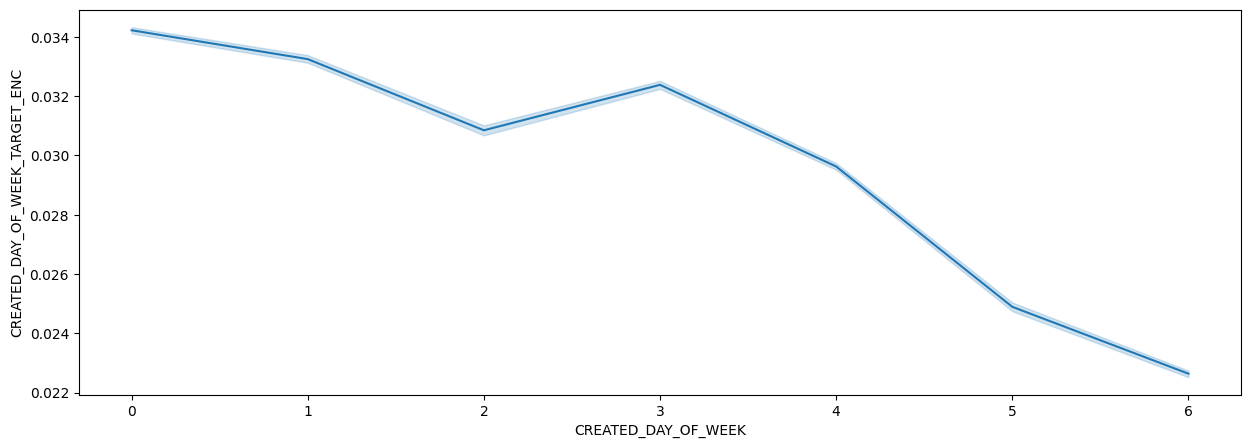

In [5]:
# visualize 'CREATED_YYYY-MM_TARGET_ENC' over time
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_users, x='CREATED_DAY_OF_WEEK', y='CREATED_DAY_OF_WEEK_TARGET_ENC')
plt.show()

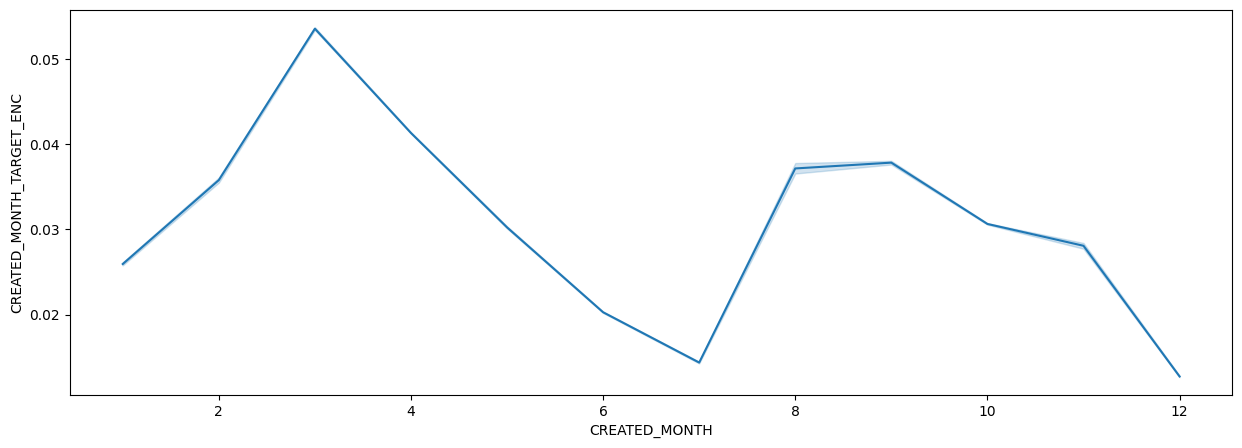

In [6]:
# visualize 'CREATED_YYYY-MM_TARGET_ENC' over time
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_users, x='CREATED_MONTH', y='CREATED_MONTH_TARGET_ENC')
plt.show()

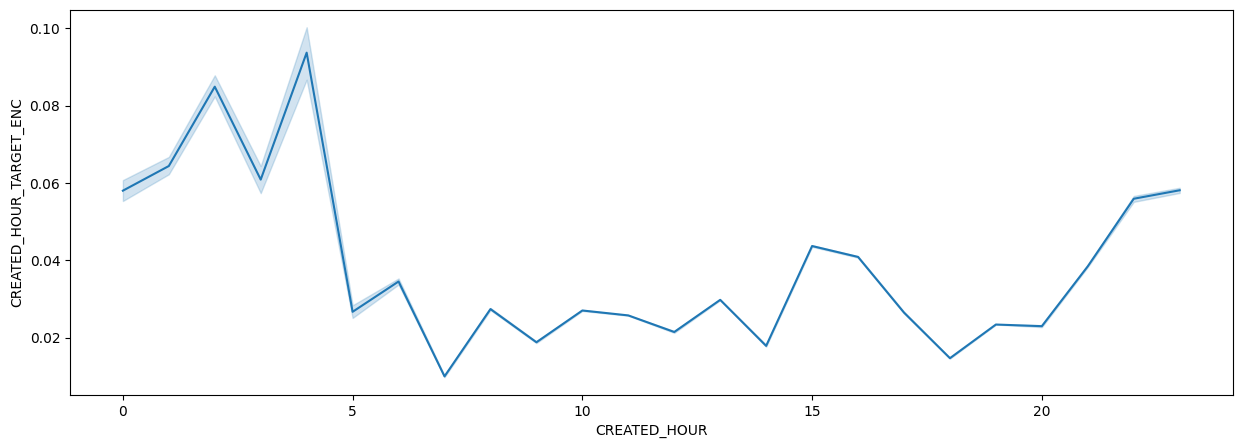

In [7]:
# visualize 'CREATED_YYYY-MM_TARGET_ENC' over time
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_users, x='CREATED_HOUR', y='CREATED_HOUR_TARGET_ENC')
plt.show()

In [8]:
df_countries = pd.read_csv('datasets/Revolut/countries.csv')
# drop 'Namibia' because it has 0 users
df_countries.dropna(inplace=True)
df_countries.head()

,CODE,NAME,CODE3,NUMCODE,PHONECODE
0,AF,Afghanistan,AFG,4,93
1,AL,Albania,ALB,8,355
2,DZ,Algeria,DZA,12,213
3,AS,American Samoa,ASM,16,1684
4,AO,Angola,AGO,24,244


In [9]:
df_currency_details = pd.read_csv('datasets/Revolut/currency_details.csv')
df_currency_details.head(2)

,CCY,EXPONENT,IS_CRYPTO
0,AED,2,False
1,AFN,2,False


In [10]:
# No null values in df_currency_details
df_currency_details.isnull().sum()

CCY          0
EXPONENT     0
IS_CRYPTO    0
dtype: int64

In [11]:
df_transactions = pd.read_csv('datasets/Revolut/transactions.csv')
df_transactions['CREATED_DATE'] = pd.to_datetime(df_transactions['CREATED_DATE'], format='ISO8601')
# impute missing values in 'AMOUNT_USD' column with mean of 'AMOUNT_USD' column
df_transactions['AMOUNT_USD'] = df_transactions['AMOUNT_USD'].fillna(weighted_average_encoding(df_transactions, 'AMOUNT_USD', ['MERCHANT_CATEGORY', 'MERCHANT_COUNTRY'], smoothing=1))
# one-hot encode 'ENTRY_METHOD' column
df_transactions = pd.get_dummies(df_transactions, columns=['ENTRY_METHOD'], dtype='int8', drop_first=True)
# one-hot encode 'TYPE' column
df_transactions = pd.get_dummies(df_transactions, columns=['TYPE'], dtype='int8', drop_first=True)
# one-hot encode 'SOURCE' column
df_transactions = pd.get_dummies(df_transactions, columns=['SOURCE'], dtype='int8', drop_first=True)
# one-hot encode 'STATE' column
df_transactions = pd.get_dummies(df_transactions, columns=['STATE'], dtype='int8', drop_first=True)
# drop MERCHANT_CATEGORY and MERCHANT_COUNTRY columns because they have too many null values
df_transactions.drop(columns=['MERCHANT_CATEGORY', 'MERCHANT_COUNTRY', 'CURRENCY', 'AMOUNT'], inplace=True)
df_transactions.head(2)

,CREATED_DATE,USER_ID,ID,AMOUNT_USD,ENTRY_METHOD_cont,ENTRY_METHOD_mags,ENTRY_METHOD_manu,ENTRY_METHOD_mcon,ENTRY_METHOD_misc,TYPE_BANK_TRANSFER,TYPE_CARD_PAYMENT,TYPE_P2P,TYPE_TOPUP,SOURCE_BRIZO,SOURCE_CRONUS,SOURCE_GAIA,SOURCE_HERA,SOURCE_INTERNAL,SOURCE_LETO,SOURCE_LIMOS,SOURCE_MINOS,SOURCE_NYX,SOURCE_OPHION,STATE_COMPLETED,STATE_DECLINED,STATE_FAILED,STATE_PENDING,STATE_RECORDED,STATE_REVERTED
0,2017-12-10 16:38:55.577,3ff52b92-d416-4e22-8cad-018f500d4bbc,367bf5f9-7cce-4683-90b9-d3c011bf4c87,3268.00000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2017-12-10 16:37:24.792,76cbaad3-4721-4a3b-92b9-3eb9e9319565,ff6802b9-360d-4efe-b09b-f99c6cac3383,925.17181,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [12]:
df_transactions_count_grouped = df_transactions.groupby('USER_ID').size()
df_transactions_count_grouped = df_transactions_count_grouped.reset_index(name='TRANSACTIONS_COUNT')
df_transactions_count_grouped.head(2)

,USER_ID,TRANSACTIONS_COUNT
0,000e88bb-d302-4fdc-b757-2b1a2c33e7d6,16
1,001032e0-8071-4baf-95b9-e50214665c2e,36


In [13]:
df_transactions_grouped = df_transactions.drop(columns=['ID', 'CREATED_DATE']).groupby('USER_ID').mean()
df_transactions_grouped.head(2)

,AMOUNT_USD,ENTRY_METHOD_cont,ENTRY_METHOD_mags,ENTRY_METHOD_manu,ENTRY_METHOD_mcon,ENTRY_METHOD_misc,TYPE_BANK_TRANSFER,TYPE_CARD_PAYMENT,TYPE_P2P,TYPE_TOPUP,SOURCE_BRIZO,SOURCE_CRONUS,SOURCE_GAIA,SOURCE_HERA,SOURCE_INTERNAL,SOURCE_LETO,SOURCE_LIMOS,SOURCE_MINOS,SOURCE_NYX,SOURCE_OPHION,STATE_COMPLETED,STATE_DECLINED,STATE_FAILED,STATE_PENDING,STATE_RECORDED,STATE_REVERTED
USER_ID,,,,,,,,,,,,,,,,,,,,,,,,,,
000e88bb-d302-4fdc-b757-2b1a2c33e7d6,5622.836418,0.500000,0.000000,0.000000,0.0,0.500000,0.0625,0.500000,0.125,0.312500,0.0,0.0625,0.500000,0.312500,0.125,0.0,0.0,0.0,0.0,0.0,0.750000,0.000000,0.0,0.0,0.0,0.250000
001032e0-8071-4baf-95b9-e50214665c2e,5145.138889,0.166667,0.138889,0.055556,0.0,0.305556,0.0000,0.638889,0.000,0.305556,0.0,0.0000,0.694444,0.305556,0.000,0.0,0.0,0.0,0.0,0.0,0.861111,0.055556,0.0,0.0,0.0,0.083333


In [14]:
df_transactions_count_grouped

,USER_ID,TRANSACTIONS_COUNT
0,000e88bb-d302-4fdc-b757-2b1a2c33e7d6,16
1,001032e0-8071-4baf-95b9-e50214665c2e,36
2,00131af8-66f0-4526-8b5f-dc2fdb26c7d7,7
3,001926be-3245-43fa-86dd-b40ee160b6f9,254
4,001cc034-5730-47c6-a70c-25f42249c9ee,4
...,...,...
8016,ffcc7fda-bbb0-4dba-b5e0-832ca5823f39,1
8017,ffd20bab-7b39-4d22-bd24-08bd36f3dbb2,6
8018,ffd3ee80-dec1-4603-bb3b-ef19d8bcc147,12
8019,ffd5d3f9-2f87-4f38-8e6d-f008ac79bb33,57


In [15]:
df_final = df_users.merge(df_transactions_grouped, left_on='ID', right_on='USER_ID', how='left', validate='one_to_one')
df_final = df_final.merge(df_transactions_count_grouped, left_on='ID', right_on='USER_ID', how='left', validate='one_to_one').drop(columns=['USER_ID'])
# drop 'STATE' due to data leakage
df_final.drop(columns=['STATE'], inplace=True)
# drop due to multicolinearity
df_final.drop(columns=['ID'], inplace=True) # 'PHONE_COUNTRY_TARGET_ENC', 'SOURCE_INTERNAL', 
# fill the null values of each column
df_final.fillna(df_final.mean(), inplace=True)
df_final.head()
print(f'Shape: {df_final.shape}')
df_final.head()

Shape: (9944, 44)


,IS_FRAUDSTER,HAS_EMAIL,BIRTH_YEAR,FAILED_SIGN_IN_ATTEMPTS,KYC_FAILED,KYC_NONE,KYC_PENDING,CREATED_DAY_OF_WEEK,CREATED_HOUR,CREATED_MONTH,CREATED_MONTH_TARGET_ENC,CREATED_DAY_OF_WEEK_TARGET_ENC,CREATED_HOUR_TARGET_ENC,PHONE_COUNTRY_TARGET_ENC,PHONE_COUNTRY_COUNT_ENC,COUNTRY_NOT_IN_PHONE_COUNTRY,COUNTRY_TARGET_ENC,AMOUNT_USD,ENTRY_METHOD_cont,ENTRY_METHOD_mags,ENTRY_METHOD_manu,ENTRY_METHOD_mcon,ENTRY_METHOD_misc,TYPE_BANK_TRANSFER,TYPE_CARD_PAYMENT,TYPE_P2P,TYPE_TOPUP,SOURCE_BRIZO,SOURCE_CRONUS,SOURCE_GAIA,SOURCE_HERA,SOURCE_INTERNAL,SOURCE_LETO,SOURCE_LIMOS,SOURCE_MINOS,SOURCE_NYX,SOURCE_OPHION,STATE_COMPLETED,STATE_DECLINED,STATE_FAILED,STATE_PENDING,STATE_RECORDED,STATE_REVERTED,TRANSACTIONS_COUNT
0,0,1,5,0,0,0,0,6,7,8,0.034783,0.023585,0.012500,0.061726,4,0,0.060231,10312.666667,0.166667,0.000000,0.000000,0.0,0.500000,0.000000,0.333333,0.000000,0.500000,0.0,0.000000,0.500000,0.500000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.833333,0.000000,0.000000,0.000000,0.0,0.166667,6.0
1,0,1,6,0,0,0,0,1,10,3,0.057235,0.033415,0.027833,0.061294,4,0,0.059317,3992.909091,0.272727,0.000000,0.000000,0.0,0.545455,0.000000,0.454545,0.181818,0.363636,0.0,0.000000,0.454545,0.363636,0.181818,0.0,0.000000,0.000000,0.0,0.0,0.818182,0.000000,0.090909,0.000000,0.0,0.090909,11.0
2,0,1,5,0,0,0,0,3,4,5,0.032397,0.033884,0.093023,0.005900,1,0,0.006410,1905.466667,0.033333,0.016667,0.300000,0.0,0.500000,0.000000,0.500000,0.383333,0.116667,0.0,0.000000,0.500000,0.116667,0.383333,0.0,0.000000,0.000000,0.0,0.0,0.733333,0.100000,0.033333,0.016667,0.0,0.116667,60.0
3,0,1,6,0,0,0,0,4,17,6,0.021119,0.028704,0.022774,0.001901,1,0,0.001887,680.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.500000,0.000000,0.000000,0.000000,0.0,0.500000,2.0
4,0,1,6,0,0,0,0,2,15,8,0.043605,0.034538,0.042017,0.060970,4,0,0.059317,132411.652893,0.198347,0.090909,0.256198,0.0,0.272727,0.057851,0.727273,0.049587,0.165289,0.0,0.008264,0.727273,0.140496,0.049587,0.0,0.024793,0.049587,0.0,0.0,0.842975,0.066116,0.016529,0.000000,0.0,0.074380,121.0


In [16]:
# check for data leakage
df_final.corr()['IS_FRAUDSTER'].sort_values(ascending=False)

IS_FRAUDSTER                      1.000000
SOURCE_MINOS                      0.559209
TYPE_BANK_TRANSFER                0.167308
COUNTRY_TARGET_ENC                0.161198
PHONE_COUNTRY_COUNT_ENC           0.159611
PHONE_COUNTRY_TARGET_ENC          0.159452
AMOUNT_USD                        0.118110
KYC_PENDING                       0.094587
CREATED_MONTH_TARGET_ENC          0.056993
STATE_DECLINED                    0.056077
KYC_FAILED                        0.050475
BIRTH_YEAR                        0.050441
CREATED_HOUR_TARGET_ENC           0.045943
ENTRY_METHOD_manu                 0.044910
HAS_EMAIL                         0.039079
ENTRY_METHOD_misc                 0.027004
STATE_COMPLETED                   0.019678
SOURCE_LIMOS                      0.012979
FAILED_SIGN_IN_ATTEMPTS           0.011833
CREATED_HOUR                      0.005490
SOURCE_BRIZO                     -0.002255
STATE_RECORDED                   -0.002255
TYPE_TOPUP                       -0.005337
SOURCE_CRON

In [17]:
# split features and target variable
X = df_final.drop(columns=['IS_FRAUDSTER'])
y = df_final['IS_FRAUDSTER']

# split the data into train, validation, and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Output the sizes of the resulting datasets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 5966 samples
Validation set size: 1989 samples
Test set size: 1989 samples


In [18]:
# # Use Isolation Forest for anomaly detection
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

# # Initialize Isolation Forest
# iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# # Fit Isolation Forest on the training set
# iso_forest.fit(X_train)

# # Predict anomalies in validation and test sets
# # Anomalies are marked as -1 by Isolation Forest
# val_preds = iso_forest.predict(X_val)
# test_preds = iso_forest.predict(X_test)

# # Convert predictions: -1 (anomaly) -> 1, 1 (normal) -> 0 for compatibility with binary classification metrics
# val_preds = np.where(val_preds == -1, 1, 0)
# test_preds = np.where(test_preds == -1, 1, 0)

# # value counts of test_preds
# print(pd.Series(test_preds).value_counts())

# # Evaluation on validation set
# print("Validation Set Evaluation")
# print(classification_report(y_val, val_preds))
# print(confusion_matrix(y_val, val_preds))

# # Evaluation on test set
# print("Test Set Evaluation")
# print(classification_report(y_test, test_preds))
# print(confusion_matrix(y_test, test_preds))

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# catboost
# from catboost import CatBoostClassifier

# Define a list of classifiers to evaluate
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=500, class_weight='balanced', random_state=42),
    'Support Vector Machine': SVC(class_weight='balanced', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=1.0, eval_metric='logloss', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
}

In [20]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Create pipelines for each classifier
pipelines = {}
for name, classifier in classifiers.items():
    if name in ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors']:
        # Use scaling and SMOTE for classifiers that benefit from scaled data
        pipelines[name] = ImbPipeline(steps=[
            ('scaler', StandardScaler()),
            # ('smote', SMOTE(random_state=42)),
            ('classifier', classifier),
        ])
    elif name in ['Random Forest', 'XGBoost', 'Decision Tree']:
        # For tree-based classifiers, skip scaling but use SMOTE
        pipelines[name] = ImbPipeline(steps=[
            # ('smote', SMOTE(random_state=42)),
            ('classifier', classifier),
        ])
    else:
        raise ValueError(f'Unknown classifier: {name}')

In [21]:
from sklearn.metrics import classification_report

# Evaluate each pipeline
for name, pipeline in pipelines.items():
    print(f"\n=== Evaluating {name} ===")
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Validation predictions
    y_pred = pipeline.predict(X_val)
    
    # Generate classification report
    print(classification_report(y_val, y_pred))

# Final test on the best model (replace with chosen classifier)
# Example: Using Random Forest
best_pipeline = pipelines['Logistic Regression']
best_pipeline.fit(X_train, y_train)
y_test_pred = best_pipeline.predict(X_test)

print("\n=== Test Set Performance (Logistic Regression) ===")
print(classification_report(y_test, y_test_pred))


=== Evaluating Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1929
           1       0.31      0.87      0.46        60

    accuracy                           0.94      1989
   macro avg       0.65      0.90      0.71      1989
weighted avg       0.97      0.94      0.95      1989


=== Evaluating Support Vector Machine ===
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1929
           1       0.49      0.83      0.61        60

    accuracy                           0.97      1989
   macro avg       0.74      0.90      0.80      1989
weighted avg       0.98      0.97      0.97      1989


=== Evaluating Random Forest ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1929
           1       0.96      0.38      0.55        60

    accuracy                           0.98      1989
   macro av

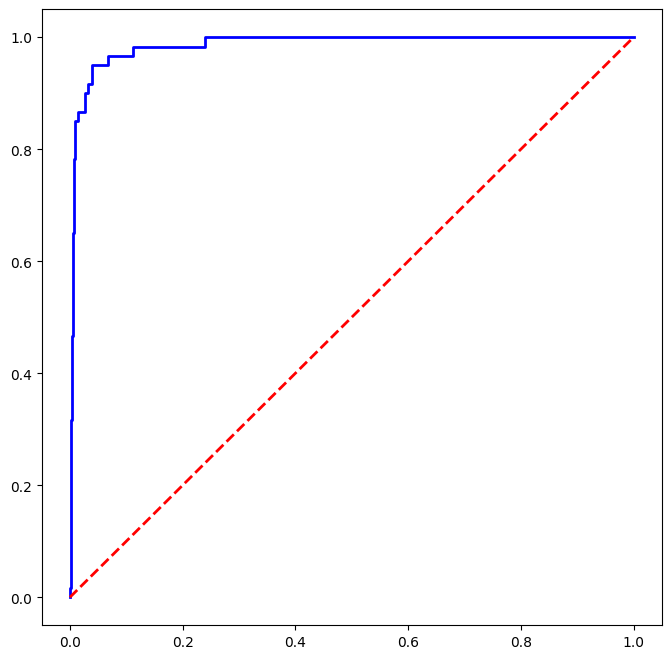

In [23]:
# Plot AUC-ROC curve for Test Set of Logistic Regression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_test_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')